In [28]:
import os
import shutil
from sklearn.model_selection import train_test_split

def split_dataset(original_dataset_dir, train_dir, val_dir, split_ratio=0.9):
    if not os.path.exists(train_dir):
        os.makedirs(train_dir)
    if not os.path.exists(val_dir):
        os.makedirs(val_dir)

    # Loop through each student's directory
    for student in os.listdir(original_dataset_dir):
        student_path = os.path.join(original_dataset_dir, student)
        if not os.path.isdir(student_path):
            continue

        images = [os.path.join(student_path, f) for f in os.listdir(student_path) if f.endswith('.jpg')]

        # Split images into training and validation sets
        train_images, val_images = train_test_split(images, train_size=split_ratio)

        # Copy files to training and validation directories
        for img in train_images:
            train_dest = os.path.join(train_dir, student)
            if not os.path.exists(train_dest):
                os.makedirs(train_dest)
            shutil.copy(img, train_dest)

        for img in val_images:
            val_dest = os.path.join(val_dir, student)
            if not os.path.exists(val_dest):
                os.makedirs(val_dest)
            shutil.copy(img, val_dest)

# Run the dataset splitting
split_dataset('dataset_frames', 'generated_dataset/train', 'generated_dataset/validation')


In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(os.listdir('dataset_frames')), activation='softmax')  # Classes + 1 for unknown
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [33]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define data augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Define data augmentation for validation data
val_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
train_generator = train_datagen.flow_from_directory(
    'generated_dataset/train',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = val_datagen.flow_from_directory(
    'generated_dataset/validation',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)


Found 868 images belonging to 8 classes.
Found 101 images belonging to 8 classes.


In [34]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 32,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // 32,
    epochs=50
)


Epoch 1/50


c:\Users\vicky\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


27/27 ━━━━━━━━━━━━━━━━━━━━ 21s 612ms/step - accuracy: 0.2723 - loss: 1.8981 - val_accuracy: 0.5521 - val_loss: 1.1171
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3438 - loss: 1.5922 - val_accuracy: 0.8000 - val_loss: 0.9519
Epoch 3/50


c:\Users\vicky\anaconda3\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


27/27 ━━━━━━━━━━━━━━━━━━━━ 12s 418ms/step - accuracy: 0.5109 - loss: 1.2950 - val_accuracy: 0.8229 - val_loss: 0.4165
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6250 - loss: 1.0770 - val_accuracy: 0.8000 - val_loss: 0.8112
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 12s 431ms/step - accuracy: 0.7285 - loss: 0.7936 - val_accuracy: 0.9792 - val_loss: 0.1226
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8750 - loss: 0.4727 - val_accuracy: 1.0000 - val_loss: 0.0326
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 14s 490ms/step - accuracy: 0.8638 - loss: 0.4231 - val_accuracy: 1.0000 - val_loss: 0.0350
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9688 - loss: 0.1202 - val_accuracy: 1.0000 - val_loss: 1.1921e-07
Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 14s 466ms/step - accuracy: 0.8962 - loss: 0.2999 - val_accuracy: 0.9688 - val_loss: 0.0620
Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8750 - loss: 0.3265 - val_accuracy: 1.0000 - val

In [35]:
# Evaluate model performance
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f'Validation Accuracy: {val_accuracy*100:.2f}%')


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 2.8361e-04 
Validation Accuracy: 100.00%


In [36]:
# Save the model
model.save('model5.h5')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
Prediction for image: nagasai


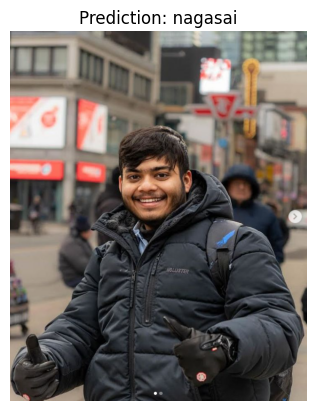

In [49]:
import numpy as np
import cv2
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Load the trained model
model = load_model('model5.h5')

def preprocess_image(image):
    # Resize the image to the input size expected by the model (128x128 pixels)
    image = cv2.resize(image, (128, 128))
    # Convert the image to an array and normalize the pixel values
    image = img_to_array(image) / 255.0
    # Add an extra dimension to fit the model input shape
    image = np.expand_dims(image, axis=0)
    return image

def recognize_face(image):
    # Make a prediction
    processed_image = preprocess_image(image)
    prediction = model.predict(processed_image)
    confidence_threshold = 0.7
    if max(prediction[0]) < confidence_threshold:
        return "Unknown"
    
    # Map the prediction to the class label
    class_labels = {v: k for k, v in train_generator.class_indices.items()}
    return class_labels[np.argmax(prediction[0])]

def recognize_from_image(image_path):
    # Read and preprocess the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Image at path '{image_path}' could not be loaded.")
        return
    prediction = recognize_face(image)
    print(f"Prediction for image: {prediction}")
    
    # Convert image from BGR to RGB (OpenCV loads images in BGR by default)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Use matplotlib to display the image
    plt.imshow(image)
    plt.title(f"Prediction: {prediction}")
    plt.axis('off')  # Hide axis labels
    plt.show()

def recognize_from_webcam():
    # Open the webcam and perform real-time prediction
    cap = cv2.VideoCapture(0)
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        prediction = recognize_face(frame)
        cv2.putText(frame, prediction, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        cv2.imshow('Face Recognition', frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

# Example usage
# Recognize from an image file
image_path = 'testdata\Screenshot 2024-08-05 191556.png'
recognize_from_image(image_path)

# Uncomment this line to test webcam recognition if your environment supports it
# recognize_from_webcam()


In [50]:
pip install rembg


  Obtaining dependency information for rembg from https://files.pythonhosted.org/packages/43/08/db43f2db001aa70f30773ee8b44d144c30534c8719a4b4b6d9c3c0604c08/rembg-2.0.58-py3-none-any.whl.metadata
  Obtaining dependency information for pooch from https://files.pythonhosted.org/packages/a8/87/77cc11c7a9ea9fd05503def69e3d18605852cd0d4b0d3b8f15bbeb3ef1d1/pooch-1.8.2-py3-none-any.whl.metadata
  Obtaining dependency information for pymatting from https://files.pythonhosted.org/packages/46/aa/d7ff530c33c654263d8775ceb50a73f636fc65edbdf09e102c47a3be391b/PyMatting-1.1.12-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/64.6 kB ? eta -:--:--
   ---------------------------------------- 64.6/64.6 kB 3.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/53.0 kB ? eta -:--:--
   ---------------------------------------- 53.0/53.0 kB ? eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
Prediction for image: ronak


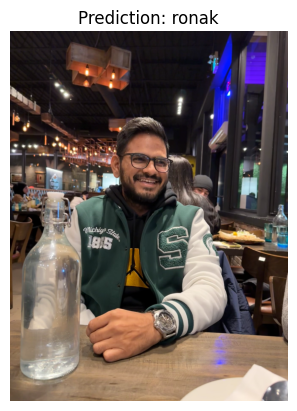

In [58]:
from rembg import remove
import numpy as np
import cv2
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Load the trained model
model = load_model('model5.h5')

def preprocess_image(image):
    # Remove background and add white background
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_no_bg = remove(image_rgb)
    
    # Convert back to BGR for OpenCV
    image_no_bg_bgr = cv2.cvtColor(image_no_bg, cv2.COLOR_RGB2BGR)

    # Create a white background
    white_background = np.ones_like(image_no_bg_bgr, dtype=np.uint8) * 255

    # Combine the image with the white background
    mask = cv2.inRange(image_no_bg_bgr, (0, 0, 0), (0, 0, 0))
    image_with_white_bg = cv2.bitwise_or(white_background, image_no_bg_bgr, mask=~mask)

    # Resize the image to the input size expected by the model (128x128 pixels)
    image_with_white_bg = cv2.resize(image_with_white_bg, (128, 128))

    # Convert the image to an array and normalize the pixel values
    image_with_white_bg = img_to_array(image_with_white_bg) / 255.0

    # Add an extra dimension to fit the model input shape
    image_with_white_bg = np.expand_dims(image_with_white_bg, axis=0)
    return image_with_white_bg

def recognize_face(image):
    # Preprocess and make a prediction
    processed_image = preprocess_image(image)
    prediction = model.predict(processed_image)
    confidence_threshold = 0.8
    if max(prediction[0]) < confidence_threshold:
        return "Unknown"
    
    # Map the prediction to the class label
    class_labels = {v: k for k, v in train_generator.class_indices.items()}
    return class_labels[np.argmax(prediction[0])]

def recognize_from_image(image_path):
    # Read and preprocess the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Image at path '{image_path}' could not be loaded.")
        return
    prediction = recognize_face(image)
    print(f"Prediction for image: {prediction}")
    
    # Convert image from BGR to RGB (OpenCV loads images in BGR by default)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Use matplotlib to display the image
    plt.imshow(image_rgb)
    plt.title(f"Prediction: {prediction}")
    plt.axis('off')  # Hide axis labels
    plt.show()

def recognize_from_webcam():
    # Open the webcam and perform real-time prediction
    cap = cv2.VideoCapture(0)
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        prediction = recognize_face(frame)
        cv2.putText(frame, prediction, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        cv2.imshow('Face Recognition', frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

# Example usage
# Recognize from an image file
image_path = 'testdata\download.png'
recognize_from_image(image_path)

# Uncomment this line to test webcam recognition if your environment supports it
# recognize_from_webcam()


In [68]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Load VGG16 without the top layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Add custom layers on top of the pre-trained base
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(os.listdir('dataset_frames')), activation='softmax')(x)

# Final model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 32,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // 32,
    epochs=50  # Start with fewer epochs and tune as needed
)


Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.2490 - loss: 2.0617 - val_accuracy: 0.7396 - val_loss: 1.4147
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5938 - loss: 1.3830 - val_accuracy: 0.6000 - val_loss: 1.4774
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.4986 - loss: 1.4869 - val_accuracy: 0.8750 - val_loss: 0.9393
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7188 - loss: 1.1884 - val_accuracy: 0.4000 - val_loss: 1.6382
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 27s 966ms/step - accuracy: 0.6774 - loss: 1.0835 - val_accuracy: 0.8854 - val_loss: 0.7352
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6875 - loss: 1.1262 - val_accuracy: 1.0000 - val_loss: 0.3511
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 26s 937ms/step - accuracy: 0.7668 - loss: 0.9095 - val_accuracy: 0.9583 - val_loss: 0.5227
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7812 - loss: 0.8039 - val_accuracy: 1.0000 - va

In [69]:
# Evaluate model performance
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f'Validation Accuracy: {val_accuracy*100:.2f}%')


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 747ms/step - accuracy: 1.0000 - loss: 0.0265
Validation Accuracy: 100.00%


In [70]:
# Save the updated model
model.save('model5_2.h5')


In [72]:
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model('model5_2.h5')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step
Prediction for image: zoeb


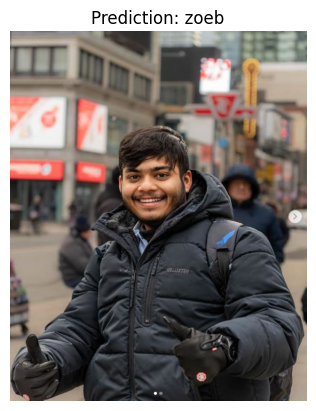

In [73]:
import numpy as np
import cv2
from tensorflow.keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt
from rembg import remove

def preprocess_image(image):
    # Remove background and add white background
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_no_bg = remove(image_rgb)
    image_no_bg_bgr = cv2.cvtColor(image_no_bg, cv2.COLOR_RGB2BGR)

    # Create a white background
    white_background = np.ones_like(image_no_bg_bgr, dtype=np.uint8) * 255
    mask = cv2.inRange(image_no_bg_bgr, (0, 0, 0), (0, 0, 0))
    image_with_white_bg = cv2.bitwise_or(white_background, image_no_bg_bgr, mask=~mask)

    # Resize the image to the input size expected by the model (128x128 pixels)
    image_with_white_bg = cv2.resize(image_with_white_bg, (128, 128))

    # Convert the image to an array and normalize the pixel values
    image_with_white_bg = img_to_array(image_with_white_bg) / 255.0

    # Add an extra dimension to fit the model input shape
    image_with_white_bg = np.expand_dims(image_with_white_bg, axis=0)
    return image_with_white_bg

def recognize_face(image):
    # Preprocess and make a prediction
    processed_image = preprocess_image(image)
    prediction = model.predict(processed_image)
    confidence_threshold = 0.7
    if max(prediction[0]) < confidence_threshold:
        return "Unknown"
    
    # Map the prediction to the class label
    class_labels = {v: k for k, v in train_generator.class_indices.items()}
    return class_labels[np.argmax(prediction[0])]

def recognize_from_image(image_path):
    # Read and preprocess the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Image at path '{image_path}' could not be loaded.")
        return
    prediction = recognize_face(image)
    print(f"Prediction for image: {prediction}")
    
    # Convert image from BGR to RGB (OpenCV loads images in BGR by default)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Use matplotlib to display the image
    plt.imshow(image_rgb)
    plt.title(f"Prediction: {prediction}")
    plt.axis('off')  # Hide axis labels
    plt.show()

def recognize_from_webcam():
    # Open the webcam and perform real-time prediction
    cap = cv2.VideoCapture(0)
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        prediction = recognize_face(frame)
        cv2.putText(frame, prediction, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        cv2.imshow('Face Recognition', frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

# Example usage
# Recognize from an image file
image_path = 'testdata/Screenshot 2024-08-05 191556.png'
recognize_from_image(image_path)

# Uncomment this line to test webcam recognition if your environment supports it
# recognize_from_webcam()
